<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2

Автор материала: Арсений Кравченко, DS team lead @ Juno. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание №6
## <center> Исследование признаков на примере поездок такси в Чикаго

Чтобы начать работу, нужно скачать данные о поездках на такси в Чикаго за первые три месяца 2016 года, а также файл `column_remapping.json` и положить их в папку `data` в репозитории (комитить эти файлы не рекомендуется – они немаленькие).

Данные доступны на Kaggle в [этом](https://www.kaggle.com/chicago/chicago-taxi-rides-2016) соревновании. Описание данных [тут](https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew).

Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1yQkyn-FoutHi5BzSHq_YVNdN6ZGJe6za4y018nAi5UM).

In [6]:
from urllib.parse import urlencode, quote_plus
import requests
base_url="https://docs.google.com/spreadsheets/d"
sheet_key="1NSdcHzMy_KoFx6hSZUuXUTwW5X6xsFY-POW2wQ4jjjs"
sheet_id="1465042576"
service="gviz/tq?"
query="select * where A='Кондратюк Вячеслав Юрьевич'"

payload = {'tqx':'out:csv',
           'sheet':sheet_id,
           'tq':query}
encoded = urlencode(payload, quote_via=quote_plus)
sheet_url = "/".join([base_url,sheet_key,service]) + encoded

#print (sheet_url)
r = requests.get(url=sheet_url)
#print(r.text)

from io import StringIO
pd.read_csv(StringIO(r.text))

,ФИО,ДЗ1,ДЗ2,ДЗ3,ДЗ4,ДЗ5,ДЗ6,ДЗ7,ДЗ8,#vis1,#vis2,kaggle,arktur,proj_ind,proj_alice,tutorials,ИТОГ
0,Кондратюк Вячеслав Юрьевич,10,10,10,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50


In [7]:
RANDOM_STATE = 42
N_FOLDS = 5

In [17]:
import json
from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

Будем играть с предсказанием цены, `fare` будет целевой переменной, тогда `trip_total` является ликом по отношению к ней – выкинем этот признак.

In [9]:
dataset_files = sorted(glob('../../data/chicago_taxi_trips_2016_*.csv'))
assert len(dataset_files) == 3

df = pd.concat(map(pd.read_csv, dataset_files))
df.drop('trip_total', axis=1, inplace=True)
target = df.pop('fare')

Загрузим словарь, ключи которого – названия признаков, а значения – опять же, словари, отображающие индексы уникальных значений признака в сами значения. Если звучит путано, посмотрите, например, на признак `pickup_longitude` в исходных данных и в словаре `column_remapping`.

In [10]:
with open('../../data/column_remapping.json') as json_file:
    column_remapping = json.load(json_file)

In [11]:
df.head()

,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,tips,tolls,extras,payment_type,company,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,85.0,2016-1-13 06:15:00,2016-1-13 06:15:00,180.0,0.40,NaN,NaN,24.0,24.0,0.00,0.0,0.0,Cash,107.0,199.0,510.0,199.0,510.0
1,2776.0,2016-1-22 09:30:00,2016-1-22 09:45:00,240.0,0.70,NaN,NaN,NaN,NaN,4.45,0.0,0.0,Credit Card,NaN,NaN,NaN,NaN,NaN
2,3168.0,2016-1-31 21:30:00,2016-1-31 21:30:00,0.0,0.00,NaN,NaN,NaN,NaN,5.00,0.0,0.0,Credit Card,119.0,NaN,NaN,NaN,NaN
3,4237.0,2016-1-23 17:30:00,2016-1-23 17:30:00,480.0,1.10,NaN,NaN,6.0,6.0,0.00,0.0,0.0,Cash,NaN,686.0,500.0,686.0,500.0
4,5710.0,2016-1-14 05:45:00,2016-1-14 06:00:00,480.0,2.71,NaN,NaN,32.0,NaN,0.00,0.0,0.0,Cash,NaN,385.0,478.0,NaN,NaN


In [12]:
assert df.shape == (5432105, 18)

In [13]:
[key for key in ["dropoff_latitude", "tips", "company", "pickup_census_tract"] if key not in column_remapping.keys()]

['tips']

**<font color='red'>Вопрос №1.</font> Какой из признаков является вещественным и из предобработки требует только заполнения/удаления пропусков? **

- dropoff_latitude
- tips
- company
- pickup_census_tract

**<font color='red'>Вопрос №2.</font> Какие методы предобработки целевой переменной могут быть уместны, судя по графику? **

- возведение в n-ую степень, n >= 2 
- ride2vec
- логарифмирование
- никакие

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


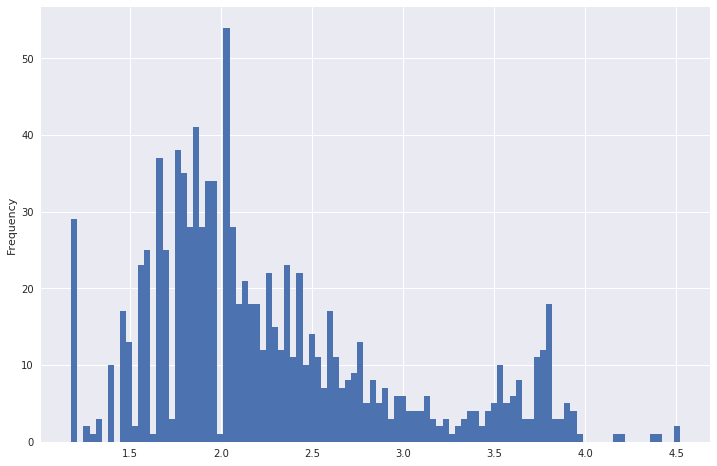

In [18]:
from scipy.stats import shapiro
data = target.sample(1000, random_state=RANDOM_STATE)
np.log(data).plot(kind="hist", bins=100);

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


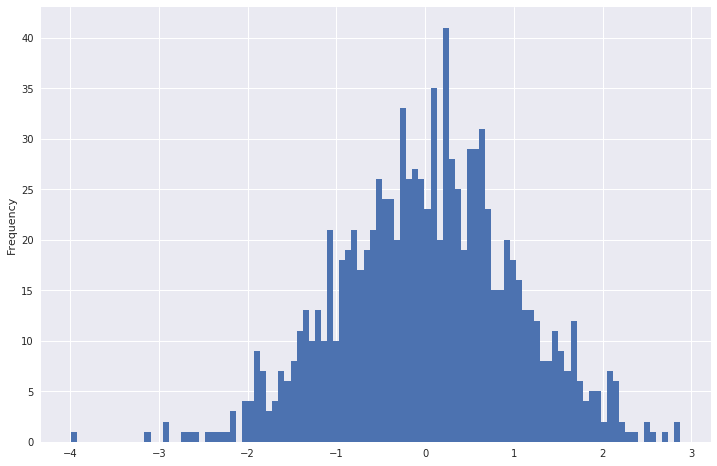

In [19]:
from scipy.stats import lognorm

data = lognorm(s=1).rvs(1000)
pd.Series(np.log(data)).plot(kind="hist", bins=100);

In [20]:
print(shapiro(data))
print(shapiro(data ** 3))
print(shapiro(np.log(data)))

(0.674310028553009, 5.216936091788791e-40)
(0.12848901748657227, 0.0)
(0.9984789490699768, 0.5409709811210632)


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


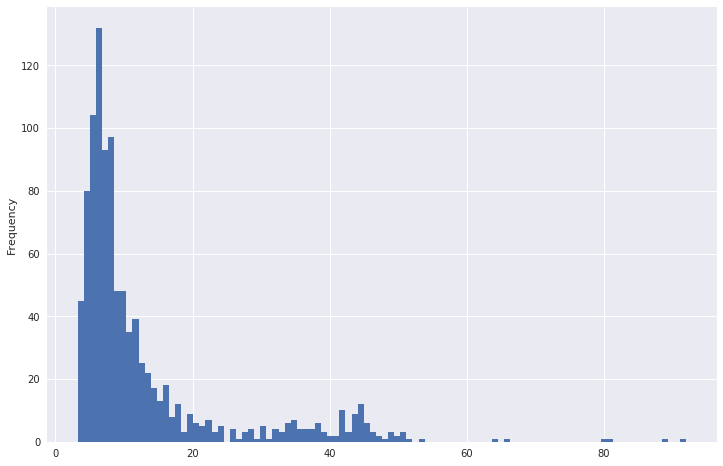

In [21]:
target.sample(1000, random_state=RANDOM_STATE).plot(kind='hist', bins=100);

**<font color='red'>Вопрос №3.</font> Каково максимальное расстояние (`great-circle distance` из библиотеки `geopy`, в км) между точками `pickup` и `dropoff`?** <br>(Для ускорения подсчета можно использовать `joblib`)
- 27.23
- 19.91
- 23.52
- 43.66

In [42]:
!pip install joblib
!pip install geopy

In [52]:
pickup_dropoff = df[['pickup_latitude', 'pickup_longitude', 
                     'dropoff_latitude', 'dropoff_longitude']].dropna()

In [57]:
pickup_dropoff = pickup_dropoff.astype(int)
pickup_dropoff = pickup_dropoff.astype(str)

In [73]:
pickup_dropoff['pickup_latitude'] = pickup_dropoff['pickup_latitude'].map(column_remapping["pickup_latitude"])
pickup_dropoff['pickup_longitude'] = pickup_dropoff['pickup_longitude'].map(column_remapping["pickup_longitude"])
pickup_dropoff['dropoff_latitude'] = pickup_dropoff['dropoff_latitude'].map(column_remapping["dropoff_latitude"])
pickup_dropoff['dropoff_longitude'] = pickup_dropoff['dropoff_longitude'].map(column_remapping["dropoff_longitude"])
pickup_dropoff.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
0,41.901206994,-87.676355989,41.901206994,-87.676355989
3,41.944226601,-87.655998182,41.944226601,-87.655998182
5,41.899602111,-87.633308037,41.96581197,-87.655878786
7,41.953582125,-87.72345239,41.953582125,-87.72345239
8,41.892507781,-87.626214906,41.884987192,-87.620992913


In [101]:
from geopy.distance import great_circle
pickup_dropoff["distance"] = pickup_dropoff.apply(
    lambda x: great_circle(
        (x['pickup_latitude'], x['pickup_longitude']),
        (x['dropoff_latitude'], x['dropoff_longitude'])
    ).kilometers,
    axis=1)

In [102]:
pickup_dropoff["distance"].max()

43.662892734777699

Давайте обучим простую модель, прежде чем пробовать добавлять признаки.

In [24]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    X_data = df[['tips', 'tolls', 'trip_seconds', 'trip_miles']]
    X_data['tips'] = X_data.tips.fillna(0)
    X_data['tolls'] = X_data.tolls.fillna(0)
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    y_data = target.fillna(0)
    
kfold = KFold(n_splits=N_FOLDS, shuffle=True)
# np.abs тут нужен,т.к. sklearn по ошибке возвращает отрицательную MSE
print(np.abs(cross_val_score(LinearRegression(), 
                X=X_data.values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error')\
    .mean()))

881.505556011
CPU times: user 7.24 s, sys: 8.63 s, total: 15.9 s
Wall time: 11 s


**<font color='red'>Вопрос №4.</font> В ячейке выше допущено несколько ошибок и неаккуратных действий.
Что из перечисленных НЕ является проблемой, влияющей на настоящее качество модели? **

- не зафиксирован random seed
- признаки разной размерности не нормированы
- взята малая подвыборка признаков
- пропуски в целевой переменной заполнены неуместным значением по умолчанию

Слегка модифицируем обработку данных.

In [28]:
%%time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_data = df[['tips', 'tolls', 'trip_seconds', 'trip_miles']]
    X_data['tips'] = X_data.tips.fillna(0)
    X_data['tolls'] = X_data.tolls.fillna(0)
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    mask = np.isnan(target)

X_data = X_data[~mask]
y_data = target[~mask]

pipeline = make_pipeline(StandardScaler(),
                         LinearRegression())

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
for exclude in ['tips', 'tolls', 'trip_seconds', 'trip_miles']:
    X_data1 = X_data.drop(exclude, axis=1)
    score = np.abs(cross_val_score(pipeline,
                    X=X_data1.values,
                    y=y_data,
                    cv=kfold,
                    scoring='neg_mean_squared_error') \
        .mean())

    print(exclude, score)

tips 908.722836037
tolls 719.773903068
trip_seconds 905.274108233
trip_miles 879.313958264
CPU times: user 33.4 s, sys: 29.5 s, total: 1min 2s
Wall time: 46.4 s


**<font color='red'>Вопрос №5.</font> Какой из признаков нужно убрать, чтобы качество модели улучшилось значительнее всего?**

- tips
- tolls 
- trip_seconds
- trip_miles
- ни один из вышеперечисленных

Давайте построим модель на двух признаках (время поездки и пройденное расстояние) и попробуем добавить еще один признак, связанный с датой. 

In [107]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    X_data = df[['trip_start_timestamp', 'trip_seconds', 'trip_miles']]
    X_data['trip_seconds'] = X_data.trip_seconds.fillna(X_data.trip_seconds.median())
    X_data['trip_miles'] = X_data.trip_miles.fillna(X_data.trip_miles.median())
    mask = np.isnan(target)

X_data = X_data[~mask]
y_data = target[~mask]

timestamp = pd.to_datetime(X_data.pop('trip_start_timestamp'))

t1 = timestamp.apply(lambda x: x.dayofweek)
t2 = timestamp.apply(lambda x: 1 if x.dayofweek in (5, 6) else 0)
t3 = timestamp.apply(lambda x: x.hour)
t4 = timestamp.apply(lambda x: x.dayofweek * 24 + x.hour)

CPU times: user 2min 19s, sys: 4.7 s, total: 2min 24s
Wall time: 2min 25s


In [112]:
%%time
pipeline = make_pipeline(StandardScaler(), LinearRegression())
kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
score = np.abs(cross_val_score(pipeline,
                X=X_data.values,
                y=y_data,
                cv=kfold,
                scoring='neg_mean_squared_error') \
    .mean())
print(score)

748.904565345
CPU times: user 6.56 s, sys: 6.54 s, total: 13.1 s
Wall time: 10.4 s


In [115]:
%%time
pipeline = make_pipeline(StandardScaler(), LinearRegression())
kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

for i, t in enumerate((t1, t2, t3, t4)):
    X_data_changed = X_data.copy()
    X_data_changed['time'] = t
    
    # Ваш код здесь
    score = np.abs(cross_val_score(pipeline,
                    X=X_data_changed.values,
                    y=y_data,
                    cv=kfold,
                    scoring='neg_mean_squared_error') \
        .mean())

    print(X_data_changed.head())
    print(i, score)

   trip_seconds  trip_miles  time
0         180.0        0.40     2
1         240.0        0.70     4
2           0.0        0.00     6
3         480.0        1.10     5
4         480.0        2.71     3
0 748.830518281
   trip_seconds  trip_miles  time
0         180.0        0.40     0
1         240.0        0.70     0
2           0.0        0.00     1
3         480.0        1.10     1
4         480.0        2.71     0
1 748.894392728
   trip_seconds  trip_miles  time
0         180.0        0.40     6
1         240.0        0.70     9
2           0.0        0.00    21
3         480.0        1.10    17
4         480.0        2.71     5
2 748.904920723
   trip_seconds  trip_miles  time
0         180.0        0.40    54
1         240.0        0.70   105
2           0.0        0.00   165
3         480.0        1.10   137
4         480.0        2.71    77
3 748.829604818
CPU times: user 34.5 s, sys: 24.4 s, total: 58.9 s
Wall time: 47.2 s


** <font color='red'>Вопрос №6.</font> Какие выводы можно сделать? **

- новые признаки не улучшают модель, т.к. автор намеренно совершил техническую ошибку
- новые признаки не улучшают модель, т.к. такова природа данных
- новые признаки улучшают модель всего на 3%
- новые признаки улучшают модель всего на 7%

** <font color='red'>Вопрос №7</font>. Отвлечемся и пофантазируем. Представим, что ввели закон, обязывающий пассажиров такси фотографировать своего водителя перед каждой поездкой и после каждой поездки; к нам, в дополнение к текущему датасету, попали эти фотографии. Как _нельзя_ было бы использовать их в предсказании цены поездки? **

- извлечь признаки водителя при помощи предобученной нейронной сети, получив значения на одном из последних полносвязных слоев
- использовать метаданные о модели телефона пассажира
- использовать геотег с обеих фотографий
- использовать время съемки

Давайте попробуем преобразовать один из признаков, чтобы избавиться от "длинного хвоста" справа.

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


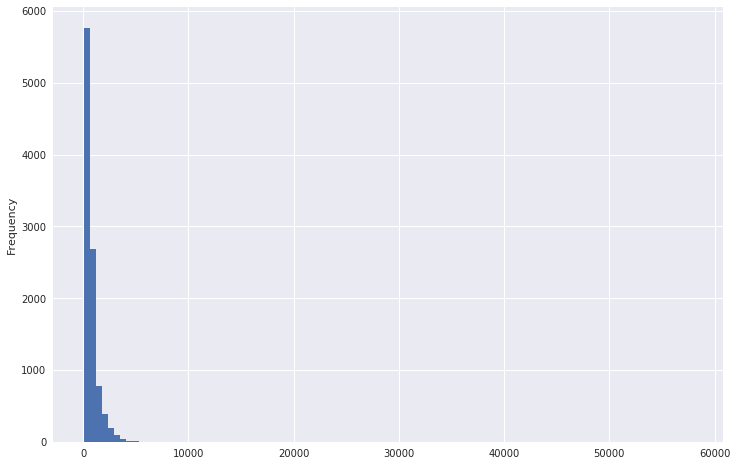

In [104]:
df_tmp = df.copy()
df_tmp = df_tmp[df_tmp.trip_seconds > 0]
seconds = df_tmp.trip_seconds

seconds.sample(10000).plot(kind='hist', bins=100);

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


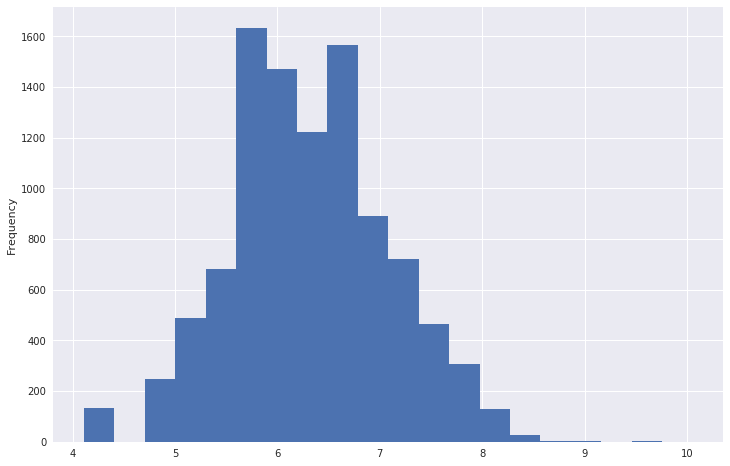

In [123]:
seconds.sample(10000).apply(lambda x: 
                            np.log(x+1)).plot(kind='hist', bins=20);

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


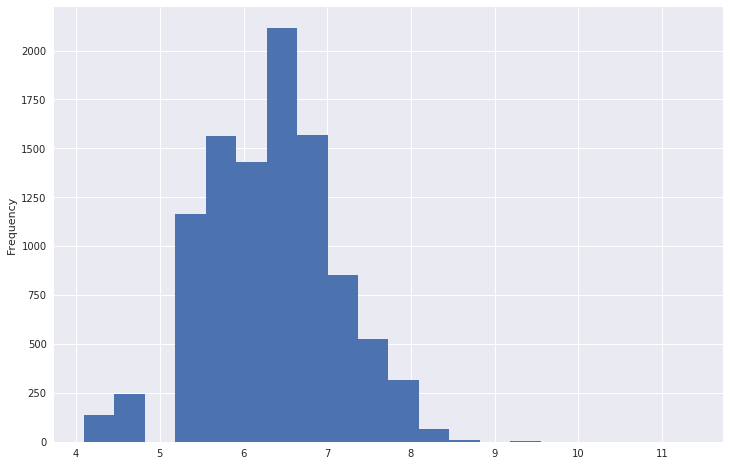

In [124]:
seconds.sample(10000).apply(lambda x: 
                            np.log(x)).plot(kind='hist', bins=20);

**<font color='red'>Вопрос №8.</font> Зачем в предыдущей ячейке используется `np.log(x + 1)`, а не просто `np.log`?**

- чтобы запутать читателей
- чтобы получить бимодальное распределение
- для скорости вычисления
- во избежание `ValueError`